# Capstone Project - Germany  


In the previous examples, we looked at comparing neighbourhoods from Toronto or New York. Big cities with huge skyscrapers and god knows, those are beautiful places to live. But what about the districts in southern Germany, where I come from. I want to apply the lessons learned in a more rural context. Which districts are similar, which districts have most inhabitants and so on. As there is a need for a direct problem statement, I will try to find a good place to build a fitness centre. 
	

First, lets import the libraries

In [34]:
import warnings                             # to ignore warnings
warnings.filterwarnings('ignore')
import time
import requests                             # library to handle requests
import json                                 # library to handle JSON file
import folium                               # map rendering library
import numpy as np                          # numeric library
import pandas as pd                         # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize   # tranform JSON file into a pandas datafram
import matplotlib.pyplot as mpp
import seaborn as sb
from bs4 import BeautifulSoup               # for scraping web pages
from geopy.geocoders import Nominatim       # convert an address into latitude and longitude values
from sklearn.cluster import KMeans          # clustering model
# Define Foursquare accounts
CLIENT_ID = '51XHGE1T5XDX0LJ1NS5YDWCEK2QT2NK3KF2BKSA5PLA1JPKB'
CLIENT_SECRET = 'GQJ3FIKNEVYMZJH00NSS0KAEBPPEMCBJWHZEW4OLTSACG0S3'
VERSION = '20200322'
limit = 500

Next cell contains functions used later in the Notebook

In [35]:
# I wanted to rewrite the function to include a polygon ... thats pretty cool. came from 
# https://stackoverflow.com/questions/40547893/four-square-venues-in-side-custom-shapes-on-google-maps-in-ios-swift/40554407#40554407?newreg=780d5d4d55b44abf9794ea7e95bbb3ee
#  but that did not work :()

# chaged it to read back only with a query.

def getNearbyVenues(names, latitudes, longitudes, radius ,categoryId):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            categoryId)
            
        # make the GET request
        print(name, url)
        results = requests.get(url).json()["response"]
        
        if 'groups' in results:
            results = results['groups'][0]['items']# return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                ) for v in results])
        else:
            results = results['venues']
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
               ) for v in results])
        


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                ]
    
    return(nearby_venues)

# debug
#venues = getNearbyVenues(names=["Ravensburg"],latitudes=[47.969713],longitudes=[9.5])


Now lets first load the JSON File with the countys. Two files are loaded. One file has all the districts, the other has the local communities. 
I create a dictionary to lookup the correect district, as the id on properties.NUTS is the identifier for this matter.
After that, I create the rest of the data I want to use for further analysis

In [36]:
with open('gemeinden_simplify200(1).geojson', 'r', encoding='utf-8') as communities_data:
    communities_data = json.load(communities_data)

with open('landkreise_simplify200(1).geojson', 'r', encoding='utf-8') as districts_data:
    districts_data = json.load(districts_data)

In [37]:
featuresCommunities = communities_data['features']
communities = json_normalize(featuresCommunities)
featuresDistricts = districts_data['features']
districts = json_normalize(featuresDistricts)

code2district = pd.Series(districts["properties.GEN"].values,index = districts["properties.NUTS"].values).to_dict()
communities_df = pd.DataFrame()


communities_df["districtName"] = communities["properties.NUTS"].map(code2district)
communities_df["communityName"] = communities["properties.GEN"]
communities_df["latitude"] = communities["properties.destatis.center_lat"].apply(lambda x: x.replace(",",".")).astype(float)
communities_df["longitude"] = communities["properties.destatis.center_lon"].apply(lambda x: x.replace(",",".")).astype(float)
communities_df["population m"] = communities["properties.destatis.population_m"]
communities_df["population w"] = communities["properties.destatis.population_w"]
communities_df["geometry.coordinates"] = communities["properties.destatis.population"]
#communities_df["polygon"] = communities["geometry.coordinates"]

#communities_df.dtypes
communities_df.head()


#communities.head()

,districtName,communityName,latitude,longitude,population m,population w,geometry.coordinates
0,Ravensburg,Boms,47.969713,9.508511,338,326,664
1,Ravensburg,Ebenweiler,47.900658,9.513264,630,583,1213
2,Ravensburg,Eichstegen,47.938739,9.498845,254,252,506
3,Ravensburg,Fleischwangen,47.879063,9.477566,364,338,702
4,Ravensburg,Guggenhausen,47.893685,9.455438,88,101,189


In [38]:
print("There are {} communities in this data set".format(communities_df.shape[0]))
print("There are {} null/nan values".format(communities_df.isnull().sum().sum()))


There are 132 communities in this data set
There are 0 null/nan values


Now lets find out the most common venues on each community, but first I want to show a map to look if it was done correctly.


In [39]:
mapbw = folium.Map(location=[communities_df["latitude"].mean(),communities_df["longitude"].mean()],zoom_start=9)

for lat,lng,borough,neighbourhood in zip(communities_df['latitude'],communities_df['longitude'],communities_df['districtName'],communities_df['communityName']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(mapbw)
mapbw

In [40]:
print("Running...")
venues = getNearbyVenues(names=communities_df['communityName'],latitudes=communities_df['latitude'],longitudes=communities_df['longitude'],radius = 5000, categoryId="4bf58dd8d48988d113951735")
print("Done...")

# save to csv that i dont have to 
venues.to_csv("temp_venues.csv",encoding="utf-8",index=False)



Running...
Done...


In [41]:
# This time i dont have to download it each time.... saves time
venues = pd.read_csv("temp_venues.csv",encoding="utf-8")

In [42]:
venues.groupby('Community').count()

,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude
Community,,,,,
Achstetten,5,5,5,5,5
Aichstetten,1,1,1,1,1
Allmannsweiler,2,2,2,2,2
Altheim,4,4,4,4,4
Altshausen,1,1,1,1,1
Amtzell,2,2,2,2,2
Argenbühl,2,2,2,2,2
Aulendorf,2,2,2,2,2
Bad Saulgau,4,4,4,4,4


In [43]:
venues.shape

(418, 6)

Seems like another round of data cleaning is required. The Venue names are not as good as I wish. So I start by removing the word "Tankstelle" and go from there

In [44]:
venues["Venue"]= venues["Venue"].apply(lambda x: x.replace("Tankstelle","").lower())
venues['Venue'].replace('', np.nan, inplace=True)
venues.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)



gas_Stations = ("esso", "agip", "ran", "avia", "bft", "shell", "sb","omv","aral","agip")
for index,row in venues.iterrows():
    venue = row["Venue"]
    found = False
    for gas_Station in gas_Stations:
        #print("Searching for: "+venue)
        if gas_Station in venue:
            #print(gas_Station)
            venues.at[index, "Venue"] =  gas_Station
            found = True
            #print("Replaced")
            break
    if not found:
        venues.drop(index,inplace=True)
venues.shape

venues=venues.drop_duplicates(subset=["Venue Latitude","Venue Longitude"])
venues

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude
0,Boms,47.969713,9.508511,shell,48.006693,9.513881
1,Boms,47.969713,9.508511,aral,48.019143,9.497020
4,Boms,47.969713,9.508511,esso,47.927761,9.544645
13,Bad Waldsee,47.922510,9.751276,avia,47.925448,9.755751
14,Bad Waldsee,47.922510,9.751276,shell,47.877550,9.704621
16,Bad Waldsee,47.922510,9.751276,esso,47.916100,9.748800
18,Ravensburg,47.783660,9.615089,shell,47.779738,9.586245
19,Ravensburg,47.783660,9.615089,aral,47.775656,9.604378
20,Ravensburg,47.783660,9.615089,aral,47.772072,9.670640
21,Ravensburg,47.783660,9.615089,aral,47.812060,9.640725


In [45]:
communities_onehot = pd.get_dummies(venues[['Venue']], prefix="", prefix_sep="")

# add Community column back to dataframe
communities_onehot['Community'] = venues['Community'] 

# move Community column to the first column
fixed_columns = [communities_onehot.columns[-1]] + list(communities_onehot.columns[:-1])
communities_onehot = communities_onehot[fixed_columns]

communities_onehot.head(10)

,Community,agip,aral,avia,bft,esso,omv,ran,sb,shell
0,Boms,0,0,0,0,0,0,0,0,1
1,Boms,0,1,0,0,0,0,0,0,0
4,Boms,0,0,0,0,1,0,0,0,0
13,Bad Waldsee,0,0,1,0,0,0,0,0,0
14,Bad Waldsee,0,0,0,0,0,0,0,0,1
16,Bad Waldsee,0,0,0,0,1,0,0,0,0
18,Ravensburg,0,0,0,0,0,0,0,0,1
19,Ravensburg,0,1,0,0,0,0,0,0,0
20,Ravensburg,0,1,0,0,0,0,0,0,0
21,Ravensburg,0,1,0,0,0,0,0,0,0


Now I have to find gas stations on this ... 



In [46]:
#gas_venues = venues.loc[venues['Venue Category'] == 'Gas Station']
gas_venues = venues
gas_venues.drop_duplicates()
filteredGas_df  = communities_df[['districtName','communityName']]
filteredGas_df = pd.merge(left = filteredGas_df, right = gas_venues, left_on ='communityName', right_on = 'Community')
filteredGas_df.head()
filteredGas_df.drop("Community",axis=1,inplace= True)
filteredGas_df.drop_duplicates(inplace=True)
print(filteredGas_df.shape)

(100, 7)


Lets see them on a Map, shall we...

In [47]:
map_gasStations = folium.Map(location=[communities_df["latitude"].mean(),communities_df["longitude"].mean()],zoom_start=9)

for lat,lng,borough,neighbourhood in zip(filteredGas_df['Venue Latitude'],filteredGas_df['Venue Longitude'],filteredGas_df['Venue'],filteredGas_df['communityName']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_gasStations)
map_gasStations

In [48]:
filteredGas_df_grouped = communities_onehot.groupby('Community').mean().reset_index()
filteredGas_df_grouped

,Community,agip,aral,avia,bft,esso,omv,ran,sb,shell
0,Achstetten,0.000000,0.333333,0.333333,0.000000,0.000000,0.0,0.333333,0.0,0.000000
1,Aichstetten,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.000000
2,Allmannsweiler,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,Altheim,0.000000,0.500000,0.500000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,Amtzell,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
5,Bad Waldsee,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.000000,0.0,0.333333
6,Bad Wurzach,0.000000,0.333333,0.333333,0.000000,0.333333,0.0,0.000000,0.0,0.000000
7,Berkheim,0.000000,0.666667,0.000000,0.333333,0.000000,0.0,0.000000,0.0,0.000000
8,Bermatingen,0.000000,0.000000,0.200000,0.400000,0.400000,0.0,0.000000,0.0,0.000000
9,Biberach an der Riß,0.166667,0.333333,0.000000,0.000000,0.000000,0.0,0.166667,0.0,0.333333


As you can see in the cell above, there are a lot of 0 values  for the frequency because not every gas station brand is there in every community. So I had to clean this data a little bit:

Because I am interested, which community is dominated by which gas station brand, I want to see the top3 brands in every community. The problem is, there are community with just one single brand ... so top 3  is just a top 1. See for example: Attenweiler has only a "ran" gas station. 

I adapted the method to only return valid values for the top venues and replace everything else with NAN in the next to cells 


In [49]:
num_top_venues = 3

for hood in filteredGas_df_grouped['Community']:
    
    print("----"+hood+"----")
    temp = filteredGas_df_grouped[filteredGas_df_grouped['Community'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp = temp[(temp[['freq']] != 0).all(axis=1)]
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Achstetten----
  venue  freq
0  aral  0.33
1  avia  0.33
2   ran  0.33


----Aichstetten----
   venue  freq
0  shell   1.0


----Allmannsweiler----
  venue  freq
0  aral   1.0


----Altheim----
  venue  freq
0  aral   0.5
1  avia   0.5


----Amtzell----
  venue  freq
0  aral   1.0


----Bad Waldsee----
   venue  freq
0   avia  0.33
1   esso  0.33
2  shell  0.33


----Bad Wurzach----
  venue  freq
0  aral  0.33
1  avia  0.33
2  esso  0.33


----Berkheim----
  venue  freq
0  aral  0.67
1   bft  0.33


----Bermatingen----
  venue  freq
0   bft   0.4
1  esso   0.4
2  avia   0.2


----Biberach an der Riß----
   venue  freq
0   aral  0.33
1  shell  0.33
2   agip  0.17


----Boms----
   venue  freq
0   aral  0.33
1   esso  0.33
2  shell  0.33


----Daisendorf----
  venue  freq
0  agip   0.5
1  esso   0.5


----Dettingen an der Iller----
   venue  freq
0   aral  0.33
1   avia  0.33
2  shell  0.33


----Eriskirch----
  venue  freq
0  esso   0.4
1  agip   0.2
2  aral   0.2


----Erlenmoos---

In [50]:
def return_most_common_venues(row, num_top_venues):
    
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    returnedValues = []
    #print("before ",returnedValues)
       
    for index,value in row_categories_sorted[0:num_top_venues].iteritems():
        #print(index , "  " , value)
        if np.isnan(value):
            #print("Delete")
            returnedValues.append(np.nan)
        else:
            returnedValues.append(index)
    #print("after ",returnedValues)
    return returnedValues



num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top restaurants
columns = ['Community']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Community'] = filteredGas_df_grouped['Community']


for ind in np.arange(filteredGas_df_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(filteredGas_df_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted


,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Achstetten,ran,avia,aral
1,Aichstetten,shell,sb,ran
2,Allmannsweiler,aral,shell,sb
3,Altheim,avia,aral,shell
4,Amtzell,aral,shell,sb
5,Bad Waldsee,shell,esso,avia
6,Bad Wurzach,esso,avia,aral
7,Berkheim,aral,bft,shell
8,Bermatingen,esso,bft,avia
9,Biberach an der Riß,shell,aral,ran


Text(0,0.5,'Frequency')

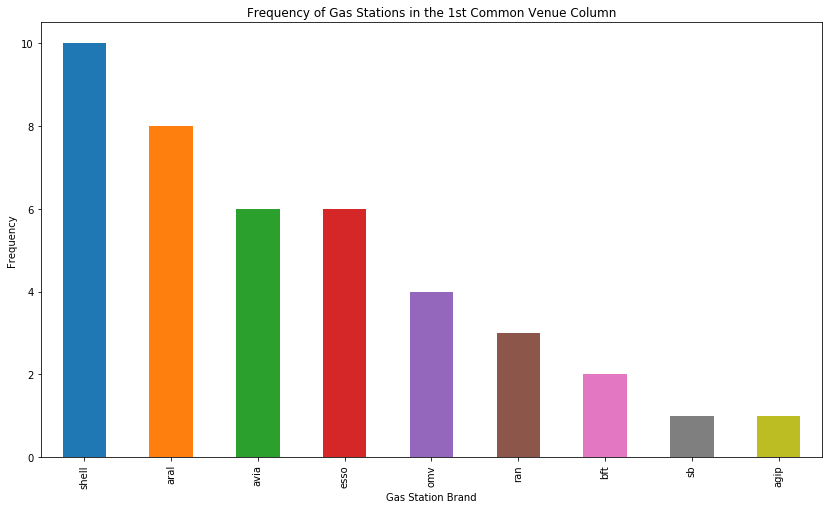

In [51]:
neighbourhoods_venues_sorted['1st Most Common Venue'].value_counts()
ax = neighbourhoods_venues_sorted['1st Most Common Venue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of Gas Stations in the 1st Common Venue Column")
ax.set_xlabel("Gas Station Brand")
ax.set_ylabel("Frequency")

Text(0,0.5,'Frequency')

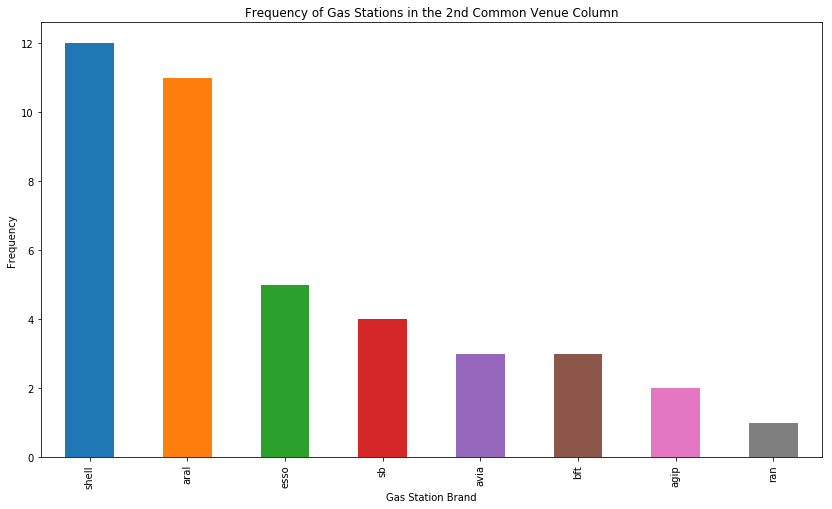

In [52]:
neighbourhoods_venues_sorted['2nd Most Common Venue'].value_counts()
ax = neighbourhoods_venues_sorted['2nd Most Common Venue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of Gas Stations in the 2nd Common Venue Column")
ax.set_xlabel("Gas Station Brand")
ax.set_ylabel("Frequency")

Text(0,0.5,'Frequency')

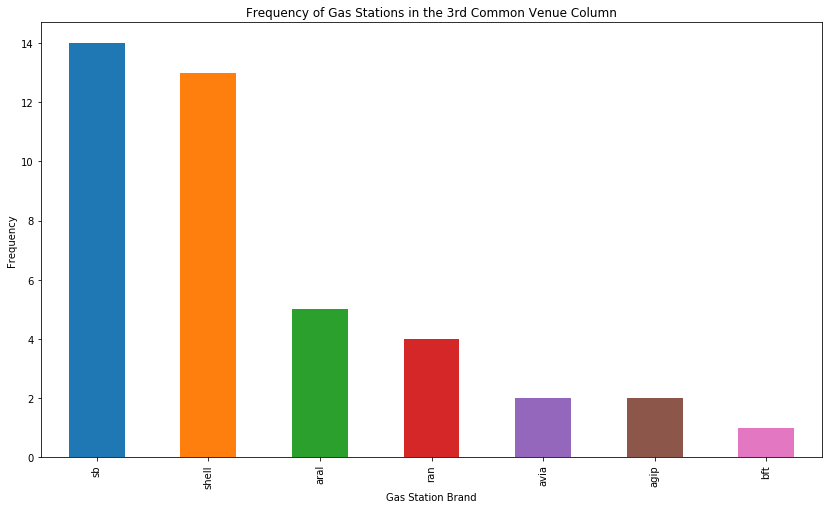

In [53]:
neighbourhoods_venues_sorted['3rd Most Common Venue'].value_counts()
ax = neighbourhoods_venues_sorted['3rd Most Common Venue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of Gas Stations in the 3rd Common Venue Column")
ax.set_xlabel("Gas Station Brand")
ax.set_ylabel("Frequency")

### Clustering Neighbourhoods According to most common gas station brands

In [54]:
# set number of clusters
kclusters = 7

filteredGas_df_grouped_clustering = filteredGas_df_grouped.drop('Community', 1)
filteredGas_df_grouped_clustering.replace(np.nan,0,inplace=True) # change back the nan values because the clustering can not handle it
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(filteredGas_df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# scoring
print(kmeans.inertia_)

5.808298059964726


In [55]:
neighbourhoods_venues_sorted['Cluster Labels'] = "" # add it just to remove it in the next line (if I run the cell again)
neighbourhoods_venues_sorted.drop(['Cluster Labels'],axis = 1,inplace = True)
# add clustering labels

neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

community_merged = communities_df

community_merged = pd.merge(left = neighbourhoods_venues_sorted, right = communities_df, left_on='Community', right_on='communityName')

community_merged.head() # check the last columns!

,Cluster Labels,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,districtName,communityName,latitude,longitude,population m,population w,geometry.coordinates
0,4,Achstetten,ran,avia,aral,Biberach,Achstetten,48.258983,9.898085,2473,2447,4920
1,3,Aichstetten,shell,sb,ran,Ravensburg,Aichstetten,47.892919,10.080670,1465,1341,2806
2,2,Allmannsweiler,aral,shell,sb,Biberach,Allmannsweiler,48.028386,9.593584,162,142,304
3,4,Altheim,avia,aral,shell,Biberach,Altheim,48.145555,9.448855,1060,1051,2111
4,2,Amtzell,aral,shell,sb,Ravensburg,Amtzell,47.706280,9.747974,2109,2104,4213


In [56]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[communities_df["latitude"].mean(),communities_df["longitude"].mean()],zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,dominatingGasStation in zip(community_merged['latitude'], community_merged['longitude'], community_merged['Community'], community_merged['Cluster Labels'],neighbourhoods_venues_sorted["1st Most Common Venue"]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ", Dominating Gas Station:" + dominatingGasStation, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As you can see there are differen clusters visible based on the gas station brand dominance. I want to see if its just the dominance of the gas station brand thats causing the clustering, therefore I will do a second map:  

This map will have two colors. The outer edge will be determined by the dominating gas brand, the fill color will be the clustering color from above. 


In [57]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters2 = folium.Map(location=[communities_df["latitude"].mean(),communities_df["longitude"].mean()],zoom_start=9)

# set color scheme for the clusters
x = np.arange(11)
ys = [i + x + (i*x)**2 for i in range(11)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,dominatingGasStation in zip(community_merged['latitude'], community_merged['longitude'], community_merged['Community'], community_merged['Cluster Labels'],neighbourhoods_venues_sorted["1st Most Common Venue"]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ", Dominating Gas Station:" + dominatingGasStation, parse_html=True)
    
    # dict for colors
    gas_Stations = ("esso", "agip", "ran", "avia", "bft", "shell", "sb","omv","aral","agip")

    folium.CircleMarker(
                
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[gas_Stations.index(dominatingGasStation)],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

# Conclusion

In this python notebook, the battle for gas continued in the suburban areas of Oberschwaben, Germany. We looked at different gas station brands like Aral, Esso and so forth. Using data science, I was able to get insight in where which brand dominated a community. 

But why?  
First of all let's say you are the Aral CEO and want to find out where to open your next gas station. This approach here can help identify where low density areas are and therefore, where it makes sense to open up a new gas station. Of course this can only be a starting point. You would have to include traffic and population as well. I will maybe enhance this in the future because I really liked working on it. 

Now what are the next steps: 
First, the population data is availabe in this data set. To include this data would be straight forward. Traffic is not so easy and requires further research. As this was just a two week's project, I am quite happy with the results. 

Thank you for your time and your interest.

May the force be with you :-D